env: MUJOCO_GL=egl


""

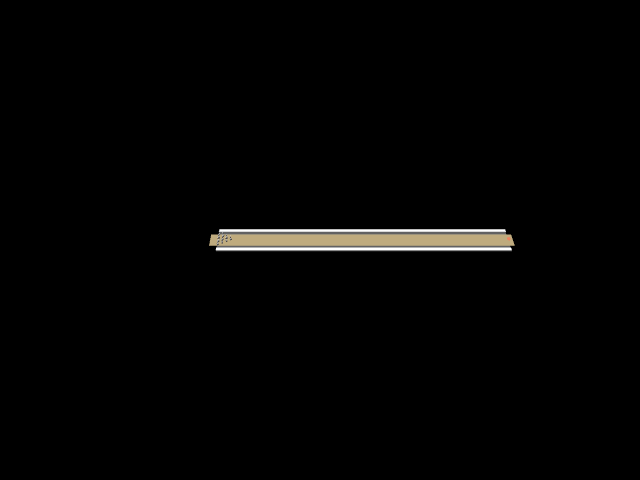

In [12]:
import distutils.util
import subprocess


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

import mujoco

#@title Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Import Renderer Class
import os
import sys

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from renderer import Renderer
model = mujoco.MjModel.from_xml_path('world.xml') #cartpole.xml') #humanoid.xml
data = mujoco.MjData(model)
renderer = Renderer(model, width=640, height=480)

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
camera_id = camera
camera.fixedcamid = 0
camera.type = mujoco.mjtCamera.mjCAMERA_FIXED

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

DURATION  = 12   # seconds
FRAMERATE = 60  # Hz

mujoco.mj_resetDataKeyframe(model, data, 1)
i=0
frames = []
while data.time < DURATION:
  # Step the simulation.
    mujoco.mj_step(model, data)
# Render and save frames.    
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels.copy())

media.show_video(frames, fps=FRAMERATE)